## Exploratory Analysis of Census Income Data - Unsupervised Machine Learning
* Objective: Predict whether income exceeds $50K/yr based on census data, also known as Adult dataset
* Data cleanup approach: 
  * Remove fnlwgt column
  * Remove education column, since education-num column is already representing the same thing
  * Remove native-country column, our focus is only on the 50K income regardless native-country
* Machine Learning Models: Unsupervised - with K-Means Clustering, BIRCH Clustering, Agglomerative Clustering, PCA (Principal Component Analysis)
* Objective: Discover patterns and clustering similar data points

### Source of information: 
* https://archive.ics.uci.edu/dataset/20/census+income
* Both adult.data and adult.test datasets are combined and duplicates are removed


## Step 1 - Install and import the required libraries

In [1]:
# Import required dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.metrics import silhouette_score #anything closets to 1 is better
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (10, 6)



## Step 2 - Data Preparation
* Upload all the source files into /resources folder and add column headers: 
  * adult.data - which is used as the train data
  * adult.test - which is used as the test data
  * the 2 datasets are combined into one called census_combined_df going forward
* Check the tables to understand data types, missing values, and fix them for better data quality

In [3]:
# Import the data
census_combined_df = pd.read_csv('./resources/census_combined.csv')

In [4]:
# Display basic information
print(f"Dataset shape: {census_combined_df.shape}")
print("\nFirst 5 rows:")
display(census_combined_df.head())


Dataset shape: (48840, 15)

First 5 rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [5]:
# Check for missing values, there are none so far
print("Missing values in each column:")
print(census_combined_df.isnull().sum())



Missing values in each column:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [6]:
# Check for "?" values which are often used to represent missing data in this dataset
# for column in df.select_dtypes(include=['object']).columns:
#    question_marks = (df[column] == ' ?').sum()
#    if question_marks > 0:
#        print(f"Column '{column}' has {question_marks} '?' values")



In [7]:
# Create a binary income variable (1 for >50K, 0 for <=50K)
census_combined_df['income_binary'] = census_combined_df['income'].apply(lambda x: 1 if '>50K' in x else 0)



In [8]:
# The workclass, occupation, and native-country columns have a value '?' which means it is a missing value. 
# Note some of these ? have extra spaces around them
# We will replace it with a NaN value
census_combined_df['workclass'] = census_combined_df['workclass'].replace(r'^\s*\?\s*$', np.nan, regex=True)
census_combined_df['occupation'] = census_combined_df['occupation'].replace(r'^\s*\?\s*$', np.nan, regex=True)
census_combined_df['native-country'] = census_combined_df['native-country'].replace(r'^\s*\?\s*$', np.nan, regex=True)

# From all records, remove any extra spaces around any values
census_combined_df = census_combined_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# From all records, remove dot character around any values
census_combined_df = census_combined_df.apply(lambda x: x.str.replace('.', '') if x.dtype == "object" else x)

In [9]:
# Display income distribution
print("Income distribution:")
print(census_combined_df['income_binary'].value_counts())
print(f"Percentage with income >50K: {census_combined_df['income_binary'].mean()*100:.2f}%")



Income distribution:
income_binary
0    37153
1    11687
Name: count, dtype: int64
Percentage with income >50K: 23.93%


In [10]:
# Drop the education column from the dataset because it's redundant with education-num
census_combined_df.drop(columns=['education'], inplace=True)

In [11]:
# Drop the native-country because majority of the data are people from the US
census_combined_df.drop(columns=['native-country'], inplace=True)

In [12]:
# Drop the fnlwgt column because it's not useful for our analysis
census_combined_df.drop(columns=['fnlwgt'], inplace=True)

In [13]:
# We'll one-hot encode the specified categorical columns
# removing education as it is a duplicate of education-num
categorical_features = ['workclass', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex']

# Fill NaN with the most common value
for col in categorical_features:
    census_combined_df[col] = census_combined_df[col].fillna(census_combined_df[col].mode()[0])


# Create another X data frame excluding the income column
X = census_combined_df.drop(columns=['income', 'income_binary'])





## Step 3 - Create a ColumnTransformer that applies the appropriate transformation to each column type
* Categorical features → one-hot encoded
* Numeric features → standard scaler

In [14]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Combine the preprocessor into a pipeline (here it only does preprocessing)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline to your data and transform it
X_scaled = pipeline.fit_transform(X)

# X_scaled is now a unified array with scaled numeric features and one-hot encoded categorical features.
print("Shape of the transformed data:", X_scaled.shape)

Shape of the transformed data: (48840, 47)


# Step 4 - PCA (Principal Component Analysis) Analysis to reduce dimensionality and visualize the data

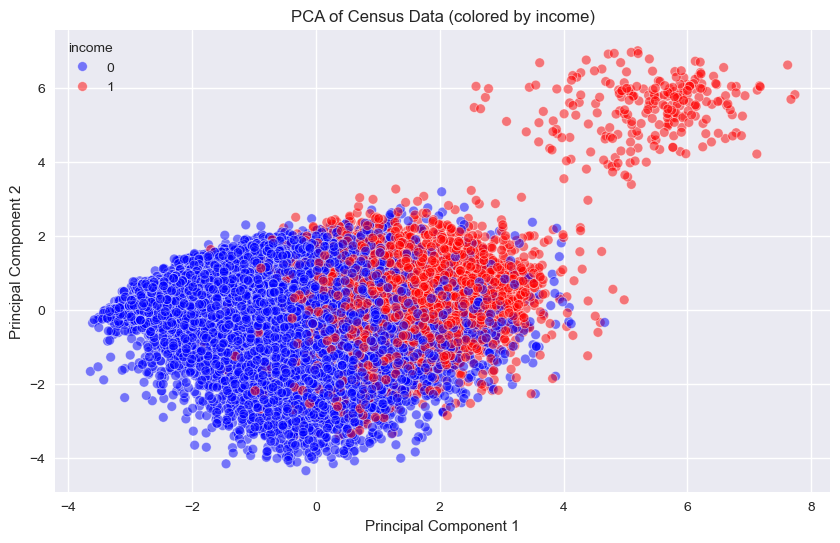

Variance explained by PC1: 18.22%
Variance explained by PC2: 12.92%
Total variance explained: 31.15%


In [15]:

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Add income information
pca_df['income'] = census_combined_df['income_binary']

# Plot PCA results colored by income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='income', data=pca_df, palette=['blue', 'red'], alpha=0.5)
plt.title('PCA of Census Data (colored by income)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")





## Step 5 - K-Means Clustering

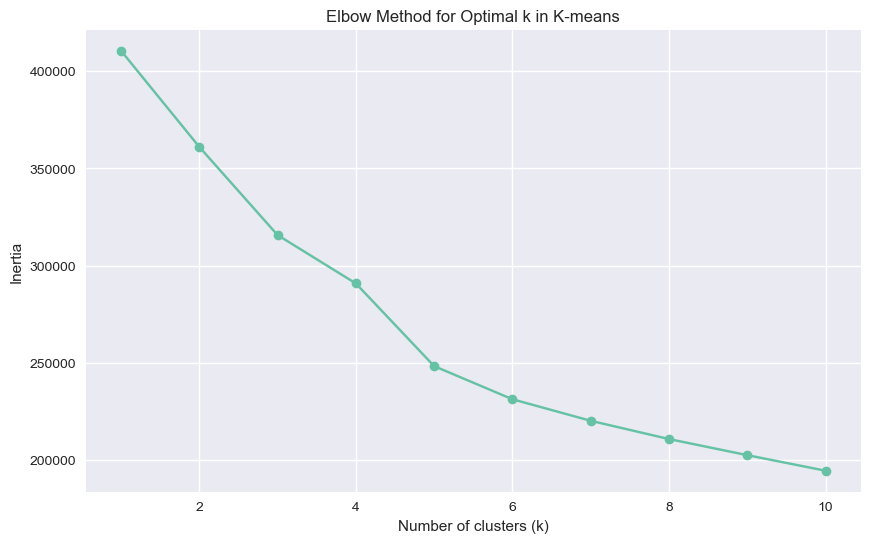

In [16]:

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k in K-means')
plt.grid(True)
plt.show()



In [17]:
# Choose optimal k (this may need visual inspection)
# For demonstration, let's select k=5
optimal_k = 5
print(f"Selected optimal k: {optimal_k}")

# %%
# Apply K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
census_combined_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)



Selected optimal k: 5


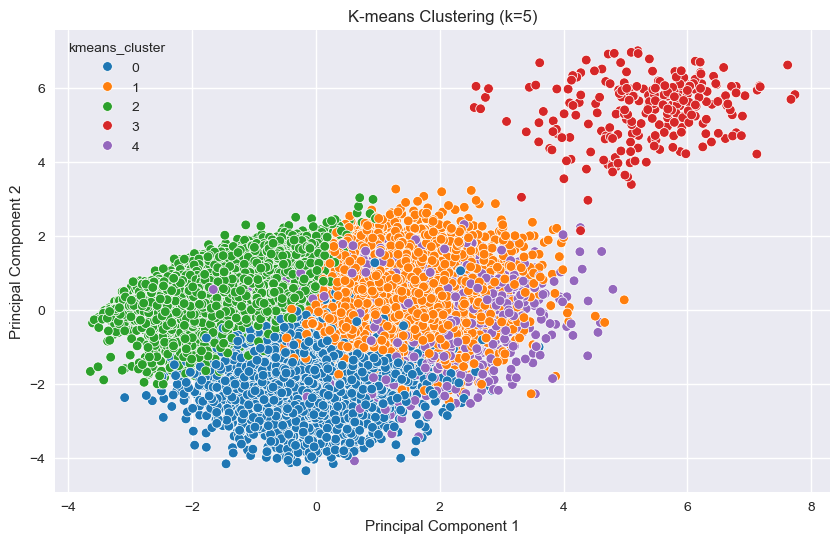

In [18]:
# Plot clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_cluster', data=pca_df.assign(kmeans_cluster=census_combined_df['kmeans_cluster']), palette='tab10')
plt.title(f'K-means Clustering (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



Income distribution within K-means clusters (%):


,<=50K,>50K
kmeans_cluster,,
0,85.718328,14.281672
1,54.284743,45.715257
2,96.019873,3.980127
3,0.000000,100.000000
4,48.926655,51.073345


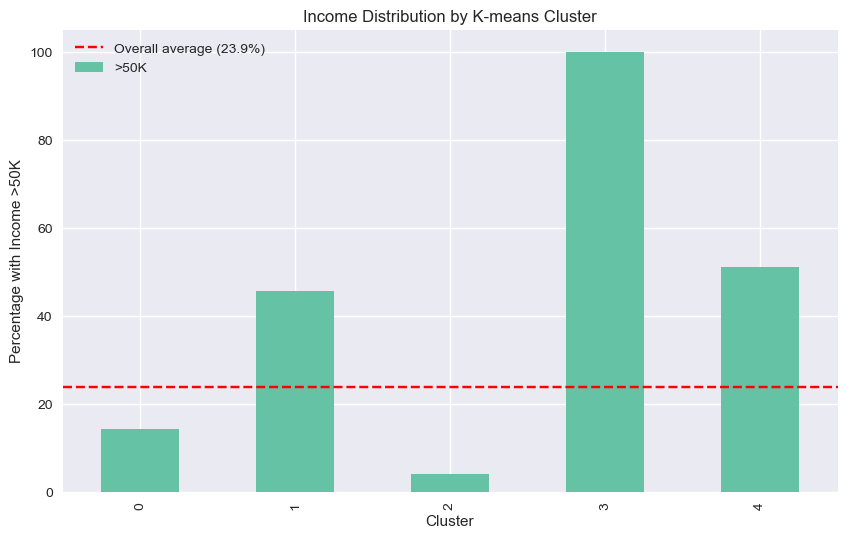

In [19]:
# Analyze clusters by income
kmeans_income = pd.crosstab(
    census_combined_df['kmeans_cluster'], 
    census_combined_df['income_binary'],
    normalize='index'
) * 100
kmeans_income.columns = ['<=50K', '>50K']
print("Income distribution within K-means clusters (%):")
display(kmeans_income)

# Visualize income percentage by cluster
plt.figure(figsize=(10, 6))
kmeans_income['>50K'].plot(kind='bar')
plt.axhline(y=census_combined_df['income_binary'].mean()*100, color='r', linestyle='--', 
           label=f'Overall average ({census_combined_df["income_binary"].mean()*100:.1f}%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage with Income >50K')
plt.title('Income Distribution by K-means Cluster')
plt.legend()
plt.grid(True, axis='y')
plt.show()



## Step 6 - BIRCH Clustering

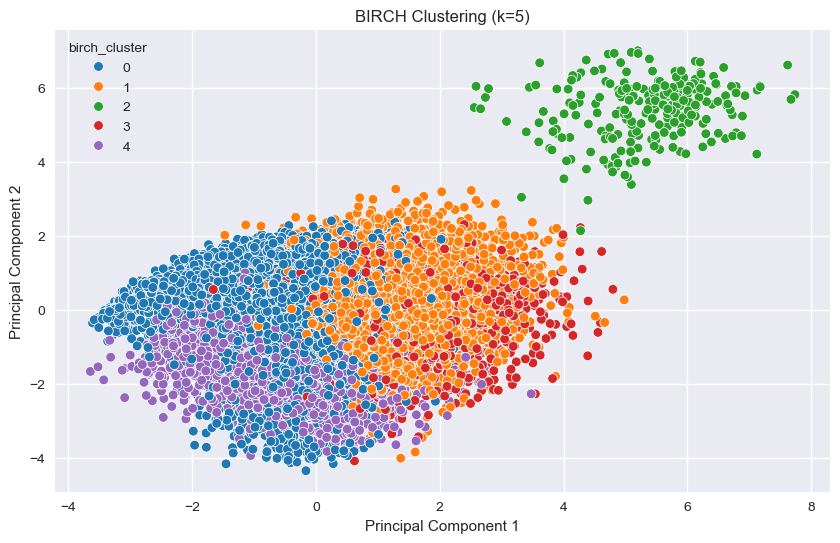

In [20]:
# Apply BIRCH clustering
birch = Birch(n_clusters=optimal_k)
census_combined_df['birch_cluster'] = birch.fit_predict(X_scaled)

# Plot BIRCH clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='birch_cluster', data=pca_df.assign(birch_cluster=census_combined_df['birch_cluster']), palette='tab10')
plt.title(f'BIRCH Clustering (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



Income distribution within BIRCH clusters (%):


,<=50K,>50K
birch_cluster,,
0,91.654733,8.345267
1,54.308962,45.691038
2,0.000000,100.000000
3,48.903803,51.096197
4,93.924118,6.075882


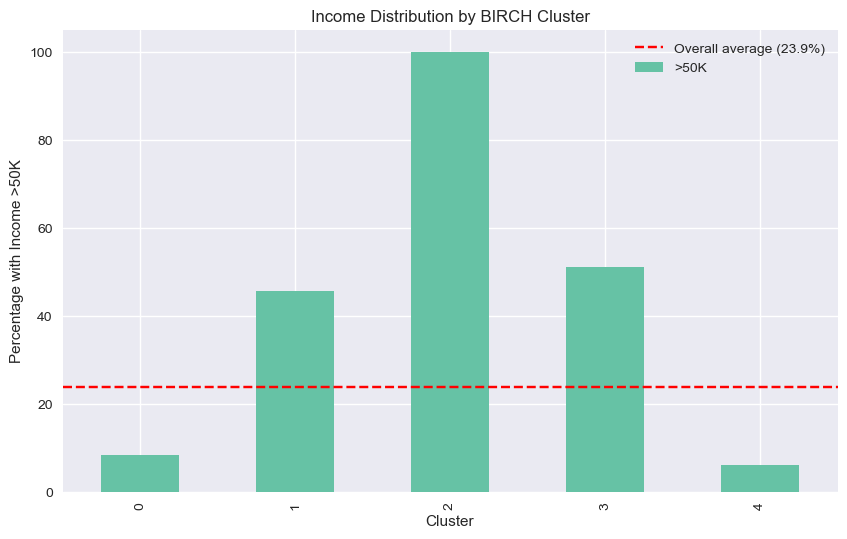

In [21]:
# Analyze BIRCH clusters by income
birch_income = pd.crosstab(
    census_combined_df['birch_cluster'], 
    census_combined_df['income_binary'],
    normalize='index'
) * 100
birch_income.columns = ['<=50K', '>50K']
print("Income distribution within BIRCH clusters (%):")
display(birch_income)

# Visualize income percentage by BIRCH cluster
plt.figure(figsize=(10, 6))
birch_income['>50K'].plot(kind='bar')
plt.axhline(y=census_combined_df['income_binary'].mean()*100, color='r', linestyle='--', 
           label=f'Overall average ({census_combined_df["income_binary"].mean()*100:.1f}%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage with Income >50K')
plt.title('Income Distribution by BIRCH Cluster')
plt.legend()
plt.grid(True, axis='y')
plt.show()



## Step 7 - Agglomerative Clustering

In [ ]:
# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
# Convert sparse matrix to dense array
X_dense = X_scaled.toarray()
census_combined_df['agg_cluster'] = agg_clustering.fit_predict(X_dense)

# Plot Agglomerative clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df.assign(agg_cluster=census_combined_df['agg_cluster']), 
                x='PC1', y='PC2', 
                hue='agg_cluster', 
                palette='tab10')
plt.title(f'Agglomerative Clustering (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Income distribution within Agglomerative clusters (%):


,<=50K,>50K
agg_cluster,,
0,86.782145,13.217855
1,96.732253,3.267747
2,0.000000,100.000000
3,48.903803,51.096197
4,53.754125,46.245875


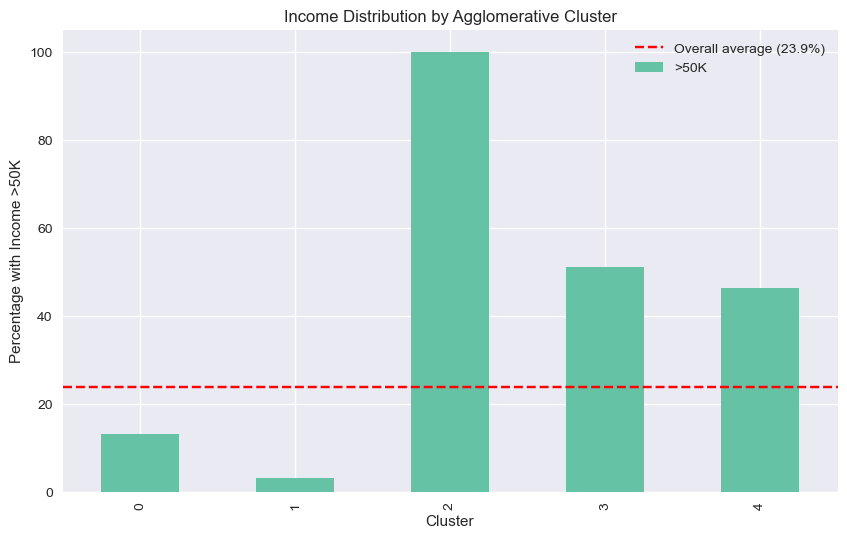

In [23]:
# Analyze Agglomerative clusters by income
agg_income = pd.crosstab(
    census_combined_df['agg_cluster'], 
    census_combined_df['income_binary'],
    normalize='index'
) * 100
agg_income.columns = ['<=50K', '>50K']
print("Income distribution within Agglomerative clusters (%):")
display(agg_income)

# Visualize income percentage by Agglomerative cluster
plt.figure(figsize=(10, 6))
agg_income['>50K'].plot(kind='bar')
plt.axhline(y=census_combined_df['income_binary'].mean()*100, color='r', linestyle='--', 
           label=f'Overall average ({census_combined_df["income_binary"].mean()*100:.1f}%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage with Income >50K')
plt.title('Income Distribution by Agglomerative Cluster')
plt.legend()
plt.grid(True, axis='y')
plt.show()



## Step 8 - Analyzing Cluster Characteristics

In [24]:
# Analyze clusters by original features
cluster_analysis = census_combined_df.groupby('kmeans_cluster').agg({
    'age': 'mean',
    'education-num': 'mean',
    'hours-per-week': 'mean',
    'capital-gain': 'mean',
    'income_binary': 'mean'  # Proportion of high income in cluster
})

print("K-means Cluster Characteristics:")
display(cluster_analysis)

# Analyze categorical feature distribution in each cluster
# Let's look at occupation distribution across clusters
occupation_by_cluster = pd.crosstab(
    census_combined_df['kmeans_cluster'], 
    census_combined_df['occupation'],
    normalize='index'
) * 100

print("\nTop occupations in each cluster (%):")
# For each cluster, show the top 3 occupations
for cluster in range(optimal_k):
    top_occupations = occupation_by_cluster.loc[cluster].sort_values(ascending=False).head(3)
    print(f"\nCluster {cluster}:")
    for occupation, percentage in top_occupations.items():
        print(f"  {occupation}: {percentage:.1f}%")



K-means Cluster Characteristics:


,age,education-num,hours-per-week,capital-gain,income_binary
kmeans_cluster,,,,,
0,54.138949,8.402887,35.692859,447.167720,0.142817
1,40.781909,11.188676,47.653650,1132.100431,0.457153
2,26.999890,9.823351,35.650511,197.995363,0.039801
3,46.610656,13.024590,50.475410,99999.000000,1.000000
4,41.774150,10.999106,43.347048,0.000000,0.510733



Top occupations in each cluster (%):

Cluster 0:
  Prof-specialty: 15.4%
  Adm-clerical: 14.8%
  Other-service: 13.0%

Cluster 1:
  Prof-specialty: 20.0%
  Exec-managerial: 19.3%
  Craft-repair: 16.8%

Cluster 2:
  Prof-specialty: 17.6%
  Adm-clerical: 16.4%
  Other-service: 15.8%

Cluster 3:
  Prof-specialty: 43.4%
  Exec-managerial: 27.5%
  Sales: 13.9%

Cluster 4:
  Prof-specialty: 23.5%
  Exec-managerial: 19.6%
  Sales: 12.6%


## Step 9 - Simple Forecasting with Clustering Results
Use cluster membership as a feature for predicting income.

In [25]:
# %% [markdown]
# ## 9. Simple Forecasting with Clustering Results
# 
# Let's use cluster membership as a feature for predicting income.

# %%
# Create dummy variables for clusters
cluster_dummies = pd.get_dummies(census_combined_df['kmeans_cluster'], prefix='cluster')

# Select a few key original features for the prediction model
forecast_features = ['age', 'education-num', 'hours-per-week', 'capital-gain']
X_forecast = pd.concat([census_combined_df[forecast_features], cluster_dummies], axis=1)
y_forecast = census_combined_df['income_binary']

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_forecast, y_forecast, test_size=0.3, random_state=42
)

# Train a linear regression model to predict income
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Feature importance
importance = pd.DataFrame({
    'Feature': X_forecast.columns,
    'Importance': np.abs(model.coef_)
})
importance = importance.sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(importance.head(10))



Model performance:
Mean Squared Error: 0.1233
R-squared: 0.3254

Feature Importance:


,Feature,Importance
7,cluster_3,2.504347
8,cluster_4,0.831183
5,cluster_1,0.731569
4,cluster_0,0.481411
6,cluster_2,0.460184
1,education-num,0.029378
0,age,0.004247
2,hours-per-week,0.001019
3,capital-gain,0.000037


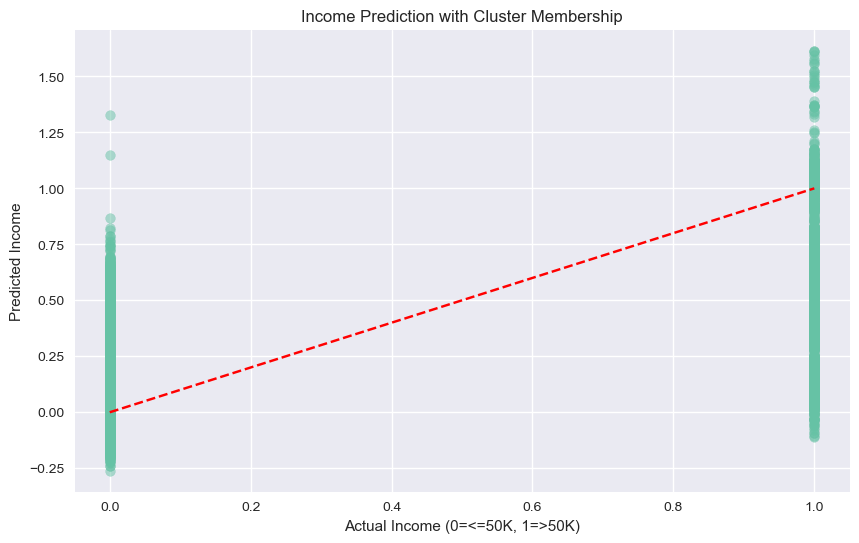

In [26]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Income (0=<=50K, 1=>50K)')
plt.ylabel('Predicted Income')
plt.title('Income Prediction with Cluster Membership')
plt.grid(True)
plt.show()



## Step 10 - Comparison of Different Clustering Methods
* Compare how the different clustering methods perform.
* Calculate silhouette scores

Clustering Method Comparison:


,Method,Silhouette Score
0,K-means,0.158338
1,BIRCH,0.133094
2,Agglomerative,0.140577


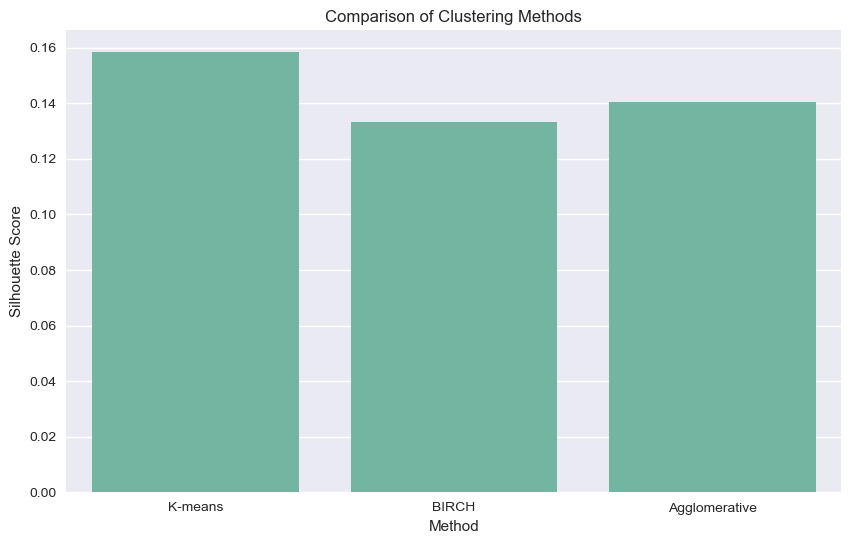

In [27]:
# Calculate silhouette scores for each method
kmeans_silhouette = silhouette_score(X_scaled, census_combined_df['kmeans_cluster'])
birch_silhouette = silhouette_score(X_scaled, census_combined_df['birch_cluster'])
agg_silhouette = silhouette_score(X_scaled, census_combined_df['agg_cluster'])

# Compare clustering methods
clustering_comparison = pd.DataFrame({
    'Method': ['K-means', 'BIRCH', 'Agglomerative'],
    'Silhouette Score': [kmeans_silhouette, birch_silhouette, agg_silhouette]
})

print("Clustering Method Comparison:")
display(clustering_comparison)

# Create a bar chart to compare methods
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Silhouette Score', data=clustering_comparison)
plt.title('Comparison of Clustering Methods')
plt.xlabel('Method')
plt.ylabel('Silhouette Score')
plt.grid(True, axis='y')
plt.show()

In [28]:
# Display the census df
display(census_combined_df.head())

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income,income_binary,kmeans_cluster,birch_cluster,agg_cluster
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K,0,0,1,0
1,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K,0,2,0,0
2,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K,0,0,1,4
3,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K,0,2,0,0
4,37,Private,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,<=50K,0,1,0,0



## Step 11 - Conclusion

In this notebook, we:

1. Converted all features to binary format:
    * Categorical features were one-hot encoded
    * Numeric features were standard scaled

2. Applied three different clustering methods to census data:
    * K-means Clustering --> gives the best performance
    * BIRCH Clustering
    * Agglomerative Clustering

3. Used PCA for dimensionality reduction and visualization
 
4. Found that the clusters identified by unsupervised learning correlate with income levels
 
5. Used cluster membership to help predict income
 
Key findings:
    * Converting all features to binary format created a unified representation for the machine learning algorithms
    * The clusters showed significant differences in income distribution
    * Clusters with higher average education and more working hours tend to have higher income
    * Different clustering methods produced similar results
    * Cluster membership provides useful information for income prediction